In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, get_train_and_val_loader, process_data

# import all the models from models module
from models import CNN3D

import warnings

# disable pyav warning
warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")

device = get_device()

You are using device: cpu


In [2]:
process_data(
    input_type='video_pack_1000', 
    # addition_parameters={'first_n_videos': 5}, 
    verbose=False,
    device=get_device(),
    skip_frames=True,
    frames_to_skip=200,
    # resize_tensors=True,
    # uniform_frames=True,
    # set_frame_count=15,
    shrink=8,
    # clean_dir=True
)

You are using device: cpu
Processing video visual to tensors..


100%|██████████| 1000/1000 [10:34:03<00:00, 38.04s/it]    


In [3]:
device = get_device()
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_1000',
    batch_size=10,
    verbose=True,
    # tensor_upper_limit=95
)

You are using device: cpu


torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [4]:
model = CNN3D(
    reduce_pool=8,
    filters=15,
    depth=30,
    dropout_rate=0.1
)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.9)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 20

train_losses = []
val_losses = []

input_verbose = False


Total parameters: 415,951


In [5]:
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=input_verbose)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=input_verbose)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


First epoch took 0.5 minutes.
Epoch 1/20, Train_Loss: 550135.94, Avg: 6876.70; Val_Loss: 86504.26, Avg: 4325.21
Epoch 2/20, Train_Loss: 541890.77, Avg: 6773.63; Val_Loss: 85395.43, Avg: 4269.77
Epoch 3/20, Train_Loss: 538710.88, Avg: 6733.89; Val_Loss: 84931.03, Avg: 4246.55
Epoch 4/20, Train_Loss: 539979.98, Avg: 6749.75; Val_Loss: 84834.62, Avg: 4241.73
Epoch 5/20, Train_Loss: 538365.55, Avg: 6729.57; Val_Loss: 84724.68, Avg: 4236.23
Epoch 6/20, Train_Loss: 536666.00, Avg: 6708.33; Val_Loss: 84630.51, Avg: 4231.53
Epoch 7/20, Train_Loss: 536774.51, Avg: 6709.68; Val_Loss: 84572.38, Avg: 4228.62
Epoch 8/20, Train_Loss: 537046.93, Avg: 6713.09; Val_Loss: 84556.88, Avg: 4227.84
Epoch 9/20, Train_Loss: 534686.28, Avg: 6683.58; Val_Loss: 84690.50, Avg: 4234.52
Epoch 10/20, Train_Loss: 534374.21, Avg: 6679.68; Val_Loss: 84318.42, Avg: 4215.92
Epoch 11/20, Train_Loss: 536215.91, Avg: 6702.70; Val_Loss: 84471.35, Avg: 4223.57
Epoch 12/20, Train_Loss: 533744.37, Avg: 6671.80; Val_Loss: 84478.

In [6]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/CNN_basic_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

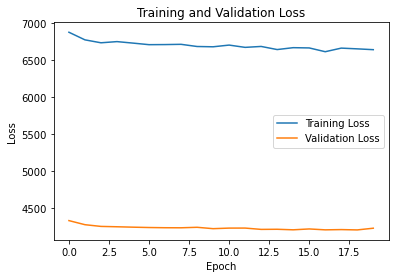

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

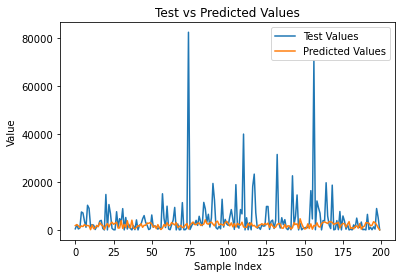

In [9]:
import matplotlib.pyplot as plt

plt.plot(val_values, label='Test Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [10]:
for i in range(len(predicted_values)):
    print(f'Test value: {val_values[i]}, Predicted Value: {predicted_values[i]}')

Test value: [462.3999938964844], Predicted Value: [1815.049560546875]
Test value: [2100.0], Predicted Value: [2240.36279296875]
Test value: [413.79998779296875], Predicted Value: [1678.043212890625]
Test value: [855.7000122070312], Predicted Value: [1012.168212890625]
Test value: [7500.0], Predicted Value: [1666.613525390625]
Test value: [7100.0], Predicted Value: [1408.30859375]
Test value: [3700.0], Predicted Value: [2241.27392578125]
Test value: [1100.0], Predicted Value: [1711.52099609375]
Test value: [10300.0], Predicted Value: [1873.9794921875]
Test value: [9000.0], Predicted Value: [1721.4840087890625]
Test value: [1400.0], Predicted Value: [114.49492645263672]
Test value: [2200.0], Predicted Value: [2093.400634765625]
Test value: [2000.0], Predicted Value: [523.9830322265625]
Test value: [178.39999389648438], Predicted Value: [841.2239990234375]
Test value: [1400.0], Predicted Value: [1889.18359375]
Test value: [1500.0], Predicted Value: [1366.771240234375]
Test value: [3700.0]

In [11]:
import numpy as np

model_mae = np.absolute(np.subtract(val_values, predicted_values)).mean()
model_mae

4222.139679002762

In [12]:
training_targets = []
for inputs, targets in train_loader:
    training_targets.extend([i.item() for i in targets])

training_targets = np.array(training_targets).reshape(-1, 1)
training_mean_as_prediction = training_targets.mean()
training_mean_as_predicted_values = [training_mean_as_prediction for i in range(len(predicted_values))]
training_mean_mae = np.absolute(np.subtract(val_values, training_mean_as_predicted_values)).mean()
training_mean_mae

6154.229260564041

In [13]:
model_mae < training_mean_mae

True